In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [3]:
from underwriting import client_surveillance_jupyter

In [146]:
COMPANY_IDENTIFIER = ['RG']
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'

In [147]:
#fetch download report and lisences
company_licenses_query = create_queries.create_company_licenses_query(COMPANY_IDENTIFIER)
company_download_summaries_query = create_queries.create_company_download_summaries_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)

company_licenses_dataframe = pd.read_sql_query(company_licenses_query, engine)
company_download_summaries_dataframe = pd.read_sql_query(company_download_summaries_query, engine)

In [148]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C11-0000496-LIC,Distributor,"CENTRAL COAST AG DISTRIBUTION, LLC",True,Active,CA-00687,Distributor,42b958d6-63bd-4b13-84a5-98f81796a9bb,None
1,CA,C11-0001495-LIC,Distributor,"Central Coast Ag Distribution, LLC",True,Active,CA-00687,Distributor,42b958d6-63bd-4b13-84a5-98f81796a9bb,None
2,CA,C11-0001094-LIC,Distributor,"Central Coast Ag Distribution, LLC",True,Active,CA-00687,Distributor,42b958d6-63bd-4b13-84a5-98f81796a9bb,None


## Check download status summaries

In [149]:
license_numbers = company_download_summaries_dataframe['license_number'].unique()
download_summary_records = company_download_summaries_dataframe.to_dict('records')

In [150]:
license_numbers

array(['C11-0000496-LIC', 'C11-0001094-LIC', 'C11-0001495-LIC'],
      dtype=object)

In [151]:
bad_download_history = client_surveillance_jupyter.check_company_license_download(license_numbers,download_summary_records)

Verifying download summaries for license C11-0000496-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-06-13

Verifying download summaries for license C11-0001094-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-06-13

Verifying download summaries for license C11-0001495-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-06-13

[SUCCESS] All download summaries look good!


In [152]:
bad_download_history

defaultdict(list, {})

## Choose license numbers

In [153]:
license_numbers = ['C11-0000496-LIC', 'C11-0001094-LIC', 'C11-0001495-LIC']

In [154]:
#license_numbers = ['C11-0000032-LIC']

## Pull data

In [155]:
company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_unknown_transfer_packages_query = create_queries.create_company_unknown_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
#     license_numbers=license_numbers,
)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_with_transactions_query = create_queries.create_company_sales_receipts_with_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    include_quantity_zero=True,
    license_numbers=license_numbers,
)



company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pd.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_unknown_transfer_packages_dataframe = pd.read_sql_query(company_unknown_transfer_packages_query, engine)
company_inventory_packages_dataframe = pd.read_sql_query(company_inventory_packages_query, engine)

In [156]:
company_outgoing_transfer_packages_dataframe['license_number'].unique()

array(['C11-0000496-LIC', 'C11-0001094-LIC'], dtype=object)

In [157]:
print(company_outgoing_transfer_packages_query)


		select
			case
				when company_deliveries.delivery_type = 'INCOMING_FROM_VENDOR' then 'INCOMING_FROM_VENDOR'
				when company_deliveries.delivery_type = 'INCOMING_UNKNOWN' then 'INCOMING_FROM_VENDOR'
				when company_deliveries.delivery_type = 'OUTGOING_UNKNOWN' then 'OUTGOING_TO_PAYOR'
				when company_deliveries.delivery_type = 'OUTGOING_TO_PAYOR' then 'OUTGOING_TO_PAYOR'
				else company_deliveries.delivery_type
			end as delivery_type,
			company_deliveries.license_number,
			metrc_transfers.manifest_number,
			metrc_transfers.created_date,
			metrc_deliveries.received_datetime,
			metrc_transfers.shipper_facility_license_number,
			metrc_transfers.shipper_facility_name,
			metrc_deliveries.recipient_facility_license_number,
			metrc_deliveries.recipient_facility_name,
			metrc_deliveries.shipment_type_name,
			metrc_deliveries.shipment_transaction_type,
			metrc_transfer_packages.package_id,
			metrc_transfer_packages.package_label,
			metrc_transfer_packages.type,
			metrc_tr

In [158]:
company_outgoing_transfer_packages_dataframe['recipient_facility_license_number'].unique()

array(['C8-0000013-LIC', 'CDPH-10003156', 'C11-0000825-LIC',
       'C11-0000050-LIC', 'C11-0000496-LIC', 'CDPH-10003334',
       'C11-0001094-LIC', 'C11-0000777-LIC', 'C8-0000012-LIC',
       'C9-0000402-LIC', 'C11-0001309-LIC', 'C11-0000955-LIC',
       'C8-0000040-LIC', 'CDPH-10003309', 'C11-0001135-LIC',
       'CCL18-0002256', 'C11-0001269-LIC', 'CDPH-10004061',
       'CDPH-10003223'], dtype=object)

In [159]:
company_incoming_transfer_packages_dataframe.head()

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipment_transaction_type,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type_1,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,receiver_wholesale_price,received_quantity,received_unit_of_measure,item_unit_weight,item_unit_weight_unit_of_measure_name
0,INCOMING_FROM_VENDOR,C11-0000496-LIC,0003617834,2022-06-13,NaT,Standard,CDPH-10003156,"Central Coast Ag Products, LLC",C11-0000496-LIC,"CENTRAL COAST AG DISTRIBUTION, LLC",Transfer,Standard,25961738,1A4060300002EE1000034808,transfer,1A40603000017E4000076452,"2021.Q3.LA.04.01.02, 2021.Q3.LA.04.01.03",Shipped,False,False,Fresh Cannabis Plant,TOK2200089 Cryoshake (FT8600),failed,None,26597.5,Grams,None,NaN,None,NaN,None
1,INCOMING_FROM_VENDOR,C11-0000496-LIC,0003617834,2022-06-13,NaT,Standard,CDPH-10003156,"Central Coast Ag Products, LLC",C11-0000496-LIC,"CENTRAL COAST AG DISTRIBUTION, LLC",Transfer,Standard,25961737,1A4060300002EE1000034809,transfer,1A40603000017E4000076452,"2021.Q3.LA.04.01.02, 2021.Q3.LA.04.01.03",Shipped,False,False,Fresh Cannabis Plant,TOK2200089 RFF (FT8500),failed,None,23043.0,Grams,None,NaN,None,NaN,None
2,INCOMING_FROM_VENDOR,C11-0000496-LIC,0003617834,2022-06-13,NaT,Standard,CDPH-10003156,"Central Coast Ag Products, LLC",C11-0000496-LIC,"CENTRAL COAST AG DISTRIBUTION, LLC",Transfer,Standard,25973281,1A4060300002EE1000035088,transfer,1A40603000017E4000075998,2021.Q4.LA.02.11.01,Shipped,False,False,Fresh Cannabis Plant,TOK2200090 RFF (FT8500),failed,None,10537.0,Grams,None,NaN,None,NaN,None
3,INCOMING_FROM_VENDOR,C11-0000496-LIC,0003617929,2022-06-13,2022-06-13 22:53:45+00:00,Standard,CDPH-10003156,"Central Coast Ag Products, LLC",C11-0000496-LIC,"CENTRAL COAST AG DISTRIBUTION, LLC",Transfer,Standard,26028409,1A4060300002EE1000034751,transfer,1A4060300002EE1000025193,"B-2351-LIMEOG-11-4-20, B2352-LIMEOG-11-04-20",Accepted,False,False,Vape Cartridge (weight - each),Surf Beast 1.0g Vape Cart,failed,None,3184.0,Each,None,3184.0,Each,1.0,Grams
4,INCOMING_FROM_VENDOR,C11-0000496-LIC,0003617834,2022-06-13,NaT,Standard,CDPH-10003156,"Central Coast Ag Products, LLC",C11-0000496-LIC,"CENTRAL COAST AG DISTRIBUTION, LLC",Transfer,Standard,25973282,1A4060300002EE1000035087,transfer,1A40603000017E4000075998,2021.Q4.LA.02.11.01,Shipped,False,False,Fresh Cannabis Plant,TOK2200090 Cryoshake (FT8600),failed,None,38699.0,Grams,None,NaN,None,NaN,None


In [160]:
company_incoming_transfer_packages_dataframe[['shipper_facility_license_number','shipper_facility_name','package_id']].groupby(['shipper_facility_license_number','shipper_facility_name']).count()

,,package_id
shipper_facility_license_number,shipper_facility_name,
C11-0000496-LIC,"CENTRAL COAST AG DISTRIBUTION, LLC",1737
C11-0000825-LIC,CANNEX HOLDINGS (CALIFORNIA) INC.,1
C11-0001094-LIC,"Central Coast Ag Distribution, LLC",198
C11-0001135-LIC,"HERBL, INC.",1
C11-0001512-LIC,"Central Coast AG Farming, LLC",18
CCL18-0002256,"Central Coast Ag Farming, LLC",100
CCL19-0005113,"Central Coast Ag Farming, LLC",1
CDPH-10003156,"Central Coast Ag Products, LLC",7449


In [91]:
company_outgoing_transfer_packages_dataframe_each = company_outgoing_transfer_packages_dataframe[company_outgoing_transfer_packages_dataframe['shipped_unit_of_measure'] == 'Each']

In [98]:
max(company_outgoing_transfer_packages_dataframe[company_outgoing_transfer_packages_dataframe['recipient_facility_license_number'] == 'C11-0001135-LIC']['created_date'])




Timestamp('2021-04-13 00:00:00')

In [95]:
company_outgoing_transfer_packages_dataframe[['recipient_facility_license_number','recipient_facility_name','shipped_quantity']].groupby(['recipient_facility_license_number','recipient_facility_name']).sum()



,,shipped_quantity
recipient_facility_license_number,recipient_facility_name,
C11-0000050-LIC,GSSC MANAGEMENT LLC,72.000
C11-0000496-LIC,"CENTRAL COAST AG DISTRIBUTION, LLC",339114.000
C11-0000777-LIC,ATLANTIC LABS LB,72.000
C11-0000825-LIC,CANNEX HOLDINGS (CALIFORNIA) INC.,2299740.000
C11-0000955-LIC,"Summit Manufacturing, LLC",1600.000
C11-0001094-LIC,"Central Coast Ag Distribution, LLC",5702212.000
C11-0001135-LIC,"HERBL, INC.",51480.000
C11-0001269-LIC,BioCani Rx Inc,470.900
C11-0001309-LIC,"GE UNITED TECHNOLOGIES II, INC.",1600.000


In [15]:
company_inventory_packages_dataframe['license_number'].unique()

array(['C11-0000496-LIC', 'C11-0001094-LIC'], dtype=object)

# Inventory

In [16]:
today = date.today()
today

datetime.date(2022, 6, 13)

In [17]:
COMPANY_IDENTIFIER

['RG']

In [18]:
# there are in total 1807 packages in its inventory 6-13-22
company_inventory_packages_dataframe['package_id'].nunique()

1807

In [19]:
company_inventory_packages_dataframe.head()

,license_number,package_id,package_label,type,packaged_date,last_modified_at,package_type,product_name,product_category_name,quantity,unit_of_measure,item_id,item_product_category_type,production_batch_number,source_production_batch_numbers,source_harvest_names,is_testing_sample,is_trade_sample,is_on_hold,archived_date,finished_date
0,C11-0000496-LIC,25978300,1A4060300005F64000007271,active,2022-06-10,2022-06-10 22:46:12+00:00,Product,Banana Punch 1.0g Live Resin,Extract (weight - each),3420.0,Each,4710097,Concentrate,,220000689,2021.Q4.CCA.13.15.03,False,False,False,None,None
1,C11-0000496-LIC,25978280,1A4060300005F64000007296,active,2022-06-10,2022-06-10 22:44:42+00:00,Product,Blue Dream 1.0g Vape Cart,Vape Cartridge (weight - each),940.0,Each,4710095,Concentrate,,220000707,"2021.Q4.TF.06.22.01, 2021.Q4.TF.06.22.02",False,False,False,None,None
2,C11-0000496-LIC,25979824,1A4060300002EE1000034749,active,2022-06-10,2022-06-10 23:21:24+00:00,Product,Kimbo Chem 1.0g Vape Cart,Vape Cartridge (weight - each),3129.0,Each,4710601,Concentrate,220000722,,"2021.Q4.CCA.16.01.03, 2021.Q4.CCA.16.02.01, 20...",False,False,False,None,None
3,C11-0000496-LIC,25978232,1A4060300005F64000007269,active,2022-06-10,2022-06-10 22:32:51+00:00,Product,Summer Lotus 1.0g Crushed Diamonds,Extract (weight - each),1350.0,Each,4685625,Concentrate,,220000692,"2020.Q2.TF.02.06.02, 2020.Q2.TF.02.06.03, 2020...",False,False,False,None,None
4,C11-0000496-LIC,25978248,1A4060300005F64000007267,active,2022-06-10,2022-06-10 22:35:07+00:00,Product,Mystic Mist 0.33g RTU Vape Cart,Vape Cartridge (weight - each),1950.0,Each,4685631,Concentrate,,220000702,"2021.Q2.CCA.12.17.02, 2021.Q2.CCA.12.17.03, 20...",False,False,False,None,None


### inventory quantity

In [20]:
# inventory quantity by product category name
company_inventory_packages_dataframe[['product_category_name','unit_of_measure','quantity']].groupby(['product_category_name','unit_of_measure']).sum()

,,quantity
product_category_name,unit_of_measure,
Extract (weight - each),Each,110357.0
Flower,Grams,53449.2
Flower (packaged - each),Each,2840.0
Fresh Cannabis Plant,Grams,2520876.0
Pre-Roll Infused,Each,33357.0
Seeds (each),Each,81010.0
Vape Cartridge (volume - each),Each,10.0
Vape Cartridge (weight - each),Each,302903.0


### inventory freshness

In [21]:
company_inventory_packages_dataframe["age"] = [today - company_inventory_packages_dataframe["packaged_date"][i] for i in range(len(company_inventory_packages_dataframe))]

company_inventory_packages_dataframe["age_int"] = [company_inventory_packages_dataframe["age"][i] / numpy.timedelta64(1, "D")
        for i in range(len(company_inventory_packages_dataframe))]

Text(0.5, 1.0, 'Vape Cartridge (weight - each)')

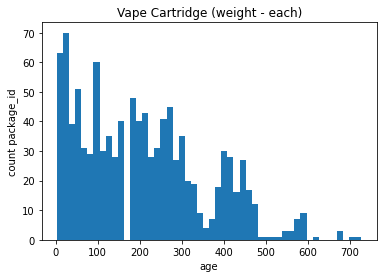

In [22]:
# histogram
ax = plt.hist(company_inventory_packages_dataframe[company_inventory_packages_dataframe['product_category_name'] == 'Vape Cartridge (weight - each)']['age_int'],bins = 50)
plt.ylabel('count package_id')
plt.xlabel('age')
plt.title('Vape Cartridge (weight - each)')



### inventory freshness by product categories

In [23]:
company_inventory_packages_dataframe[['product_category_name','unit_of_measure','age_int']].groupby(['product_category_name','unit_of_measure']).describe()

age_int              \
                                                 count        mean   
product_category_name          unit_of_measure                       
Extract (weight - each)        Each              495.0  244.541414   
Flower                         Grams               6.0  102.500000   
Flower (packaged - each)       Each                5.0  103.000000   
Fresh Cannabis Plant           Grams             101.0   45.693069   
Pre-Roll Infused               Each              145.0   64.565517   
Seeds (each)                   Each                1.0  479.000000   
Vape Cartridge (volume - each) Each                1.0  364.000000   
Vape Cartridge (weight - each) Each             1053.0  205.938272   

                                                                          \
                                                       std    min    25%   
product_category_name          unit_of_measure                             
Extract (weight - each)        Each             154.852136    3.0  113.0   
Flower                         Grams             17.352233   68.0  105.0   
Flower (packaged - each)       Each               3.937004   96.0  104.0   
Fresh Cannabis Plant           Grams             25.876144    5.0   26.0   
Pre-Roll Infused               Each              29.919989    4.0   45.0   
Seeds (each)                   Each                    NaN  479.0  479.0   
Vape Cartridge (volume - each) Each                    NaN  364.0  364.0   
Vape Cartridge (weight - each) Each             149.083356    3.0   81.0   

                                                                     
                                                  50%    75%    max  
product_category_name          unit_of_measure                       
Extract (weight - each)        Each             237.0  381.0  614.0  
Flower                         Grams            107.5  111.5  115.0  
Flower (packaged - each)       Each             105.0  105.0  105.0  
Fresh Cannabis Plant           Grams             45.0   66.0  158.0  
Pre-Roll Infused               Each              61.0   90.0  147.0  
Seeds (each)                   Each             479.0  479.0  479.0  
Vape Cartridge (volume - each) Each             364.0  364.0  364.0  
Vape Cartridge (weight - each) Each             192.0  297.0  728.0

In [27]:
print(company_inventory_packages_dataframe[company_inventory_packages_dataframe['age_int'] <= 90]['package_id'].nunique() / company_inventory_packages_dataframe['package_id'].nunique())
print(company_inventory_packages_dataframe[company_inventory_packages_dataframe['age_int'] <= 180]['package_id'].nunique() / company_inventory_packages_dataframe['package_id'].nunique())
print(company_inventory_packages_dataframe[company_inventory_packages_dataframe['age_int'] <= 270]['package_id'].nunique() / company_inventory_packages_dataframe['package_id'].nunique())
print(company_inventory_packages_dataframe[company_inventory_packages_dataframe['age_int'] <= 360]['package_id'].nunique() / company_inventory_packages_dataframe['package_id'].nunique())



0.3303818483674599
0.5085777531820698
0.7055893746541229
0.8190370780298838


# Turnover

In [28]:
company_outgoing_transfer_packages_dataframe['created_date'] = pd.to_datetime(company_outgoing_transfer_packages_dataframe['created_date'])

In [29]:
# recent 3 month outgoing packages 
recent_outgoing_3m = company_outgoing_transfer_packages_dataframe[company_outgoing_transfer_packages_dataframe['created_date'] >= '2022-03-13']
recent_outgoing_1m = company_outgoing_transfer_packages_dataframe[company_outgoing_transfer_packages_dataframe['created_date'] >= '2022-05-13']



In [30]:
recent_outgoing_3m.head()

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,received_quantity,received_unit_of_measure,receiver_wholesale_price,item_unit_weight,item_unit_weight_unit_of_measure_name
0,OUTGOING_TO_PAYOR,C11-0001094-LIC,0003614618,2022-06-13,2022-06-13 14:18:46+00:00,C11-0001094-LIC,"Central Coast Ag Distribution, LLC",CDPH-10003156,"Central Coast Ag Products, LLC",Transfer,Standard,25903040,1A4060300002EE1000034464,transfer,1A4060300002EE1000034646,"2020.Q4.TF.18.01.03, 2020.Q4.TF.18.01.04, 2020...",Accepted,False,False,Pre-Roll Infused,TKB2200129 IRJ (PS4000),failed,None,14125.0,Each,14125.0,Each,None,0.50,Grams
1,OUTGOING_TO_PAYOR,C11-0001094-LIC,0003614618,2022-06-13,2022-06-13 14:18:46+00:00,C11-0001094-LIC,"Central Coast Ag Distribution, LLC",CDPH-10003156,"Central Coast Ag Products, LLC",Transfer,Standard,25813730,1A4060300002EE1000034462,transfer,1A4060300002EE1000034554,"2019.Q3.CCA.07.09.02, 2019.Q3.CCA.07.09.03, 20...",Accepted,False,False,Pre-Roll Infused,TKB2200127 IRJ (PS4000),failed,None,12524.0,Each,12524.0,Each,None,0.50,Grams
2,OUTGOING_TO_PAYOR,C11-0000496-LIC,0003606686,2022-06-10,2022-06-11 15:57:05+00:00,C11-0000496-LIC,"CENTRAL COAST AG DISTRIBUTION, LLC",C8-0000013-LIC,SC LABORATORIES CALIFORNIA LLC,Transfer,Standard,25957729,1A4060300005F64000007386,transfer,1A4060300002EE1000034816,"2019.Q3.CCA.07.09.02, 2019.Q3.CCA.07.09.03, 20...",Accepted,True,False,Pre-Roll Infused,220000750 Sunset Fuego (3) 0.5g Joints Lab Sample,failed,None,13.0,Each,13.0,Each,None,1.50,Grams
3,OUTGOING_TO_PAYOR,C11-0000496-LIC,0003606686,2022-06-10,2022-06-11 15:57:05+00:00,C11-0000496-LIC,"CENTRAL COAST AG DISTRIBUTION, LLC",C8-0000013-LIC,SC LABORATORIES CALIFORNIA LLC,Transfer,Standard,25958144,1A4060300005F64000007380,transfer,1A4060300002EE1000034788,"2021.Q4.CCA.11.25.01, 2021.Q4.CCA.11.25.02, 20...",Accepted,True,False,Vape Cartridge (weight - each),220000741 Blue Dream 0.5g Vape Cart Lab Sample,failed,None,36.0,Each,36.0,Each,None,0.50,Grams
4,OUTGOING_TO_PAYOR,C11-0000496-LIC,0003606686,2022-06-10,2022-06-11 15:57:05+00:00,C11-0000496-LIC,"CENTRAL COAST AG DISTRIBUTION, LLC",C8-0000013-LIC,SC LABORATORIES CALIFORNIA LLC,Transfer,Standard,25955481,1A4060300005F64000007377,transfer,1A4060300002EE1000034723,"2021.Q2.CCA.16.10.01, 2021.Q2.CCA.16.10.02, 20...",Accepted,True,False,Vape Cartridge (weight - each),220000719 Sweet Fire OG 0.33g RTU Vape Cart La...,failed,None,55.0,Each,55.0,Each,None,0.33,Grams


In [31]:
recent_outgoing_3m_package = recent_outgoing_3m[['package_id','product_category_name','shipped_unit_of_measure','shipped_quantity']].\
groupby(['package_id','shipped_unit_of_measure','product_category_name']).sum().reset_index()

recent_outgoing_1m_package = recent_outgoing_1m[['package_id','shipped_unit_of_measure','product_category_name','shipped_quantity']].\
groupby(['package_id','shipped_unit_of_measure','product_category_name']).sum().reset_index()

In [32]:
recent_outgoing_3m_package.columns = ['package_id','unit_of_measure','product_category_name','shipped_quantity']
recent_outgoing_1m_package.columns = ['package_id','unit_of_measure','product_category_name','shipped_quantity']

In [35]:
recent_outgoing_1m_package

,package_id,unit_of_measure,product_category_name,shipped_quantity
0,19778466,Each,Extract (weight - each),4912.0
1,23785243,Grams,Fresh Cannabis Plant,31099.6
2,23927022,Grams,Fresh Cannabis Plant,11881.0
3,24036175,Each,Extract (weight - each),3111.0
4,24074644,Grams,Fresh Cannabis Plant,19688.4
...,...,...,...,...
308,25957915,Each,Vape Cartridge (weight - each),36.0
309,25958144,Each,Vape Cartridge (weight - each),36.0
310,25958150,Each,Vape Cartridge (weight - each),20.0
311,25958152,Each,Vape Cartridge (weight - each),20.0


In [39]:
recent_outgoing_3m_package[['product_category_name','shipped_quantity','unit_of_measure']].\
groupby(['product_category_name','unit_of_measure']).sum()


shipped_quantity
product_category_name          unit_of_measure                  
Extract (weight - each)        Each                     541971.0
Flower                         Grams                      6547.0
Flower (packaged - each)       Each                        567.0
Fresh Cannabis Plant           Grams                    209219.8
                               Pounds                      464.0
Pre-Roll Infused               Each                     850334.0
Vape Cartridge (weight - each) Each                    1413550.0

In [36]:
#recent_outgoing_3m_package.to_csv('rg_recent_outgoing_3m_package_0613.csv')

In [37]:
#recent_outgoing_1m_package.to_csv('rg_recent_outgoing_1m_package_0613.csv')

In [60]:
joined_3m = company_inventory_packages_dataframe.merge(recent_outgoing_3m,how = 'left', left_on = ['package_id','unit_of_measure'],right_on = ['package_id','shipped_unit_of_measure'])
joined_1m = company_inventory_packages_dataframe.merge(recent_outgoing_1m,how = 'left', left_on = ['package_id','unit_of_measure'],right_on = ['package_id','shipped_unit_of_measure'])




In [61]:
joined_1m[joined_1m['shipped_quantity'].notnull()]['package_id'].nunique()


9

In [63]:
joined_3m[joined_3m['shipped_quantity'].notnull()]['package_id'].nunique()


270

In [64]:
move_3m= joined_3m[joined_3m['shipped_quantity'].notnull()]
move_3m['package_id'].nunique()

270

In [65]:
move_1m= joined_1m[joined_1m['shipped_quantity'].notnull()]
move_1m['package_id'].nunique()

9

In [67]:
move_3m['package_id'].nunique() / company_inventory_packages_dataframe['package_id'].nunique()

0.14941892639734367

In [73]:
move_1m['package_id'].nunique() / company_inventory_packages_dataframe['package_id'].nunique()

0.004980630879911455

In [77]:
move_3m['packaged_date'] = pd.to_datetime(move_3m['packaged_date'])
move_3m['diff'] = move_3m['created_date'] - move_3m['packaged_date']
move_3m = move_3m.reset_index()
move_3m["diff_int"] = [move_3m["diff"][i] / numpy.timedelta64(1, "D")
        for i in range(len(move_3m))]

move_1m['packaged_date'] = pd.to_datetime(move_1m['packaged_date'])
move_1m['diff'] = move_1m['created_date'] - move_1m['packaged_date']
move_1m = move_1m.reset_index()
move_1m["diff_int"] = [move_1m["diff"][i] / numpy.timedelta64(1, "D")
        for i in range(len(move_1m))]

In [78]:
move_3m[['product_category_name_x','diff_int','unit_of_measure']].\
groupby(['product_category_name_x','unit_of_measure']).describe()

diff_int                        \
                                                  count       mean        std   
product_category_name_x        unit_of_measure                                  
Extract (weight - each)        Each                46.0  38.478261  38.456174   
Fresh Cannabis Plant           Grams                3.0  34.333333  19.139836   
Pre-Roll Infused               Each               100.0   4.750000   3.373620   
Vape Cartridge (weight - each) Each               180.0  34.100000  17.547095   

                                                                                
                                                 min   25%   50%    75%    max  
product_category_name_x        unit_of_measure                                  
Extract (weight - each)        Each              1.0  15.0  23.0  57.25  204.0  
Fresh Cannabis Plant           Grams            13.0  26.5  40.0  45.00   50.0  
Pre-Roll Infused               Each              0.0   2.0   4.5   7.00   13.0  
Vape Cartridge (weight - each) Each              1.0  21.0  32.0  41.00  105.0

In [79]:
move_1m[['product_category_name_x','diff_int','unit_of_measure']].\
groupby(['product_category_name_x','unit_of_measure']).describe()

diff_int                   \
                                                  count  mean        std   
product_category_name_x        unit_of_measure                             
Extract (weight - each)        Each                 7.0  54.0  66.513157   
Fresh Cannabis Plant           Grams                2.0  31.5  26.162951   
Pre-Roll Infused               Each                 2.0   7.0   4.242641   
Vape Cartridge (weight - each) Each                 6.0  30.5   0.547723   

                                                                          \
                                                 min    25%   50%    75%   
product_category_name_x        unit_of_measure                             
Extract (weight - each)        Each             22.0  22.00  36.0  36.00   
Fresh Cannabis Plant           Grams            13.0  22.25  31.5  40.75   
Pre-Roll Infused               Each              4.0   5.50   7.0   8.50   
Vape Cartridge (weight - each) Each             30.0  30.00  30.5  31.00   

                                                       
                                                  max  
product_category_name_x        unit_of_measure         
Extract (weight - each)        Each             204.0  
Fresh Cannabis Plant           Grams             50.0  
Pre-Roll Infused               Each              10.0  
Vape Cartridge (weight - each) Each              31.0

# HERBL

In [99]:
COMPANY_IDENTIFIER = ['HBL']
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'

In [100]:
#fetch download report and lisences
company_licenses_query = create_queries.create_company_licenses_query(COMPANY_IDENTIFIER)
company_download_summaries_query = create_queries.create_company_download_summaries_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)

company_licenses_dataframe = pd.read_sql_query(company_licenses_query, engine)
company_download_summaries_dataframe = pd.read_sql_query(company_download_summaries_query, engine)

In [101]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C11-0000794-LIC,Distributor,HERBL INC,True,Active,CA-01692,Distributor,902aadc8-5cd3-4147-9591-d3b4d265eba3,None
1,CA,C11-0000975-LIC,Distributor,HERBL INC,True,Active,CA-01692,Distributor,902aadc8-5cd3-4147-9591-d3b4d265eba3,None
2,CA,C11-0001080-LIC,Distributor,HERBL INC.,True,Active,CA-01692,Distributor,902aadc8-5cd3-4147-9591-d3b4d265eba3,None
3,CA,C11-0001135-LIC,Distributor,"HERBL, INC.",True,Active,CA-01692,Distributor,902aadc8-5cd3-4147-9591-d3b4d265eba3,None


In [102]:
license_numbers = company_download_summaries_dataframe['license_number'].unique()
download_summary_records = company_download_summaries_dataframe.to_dict('records')

In [105]:
license_numbers = list(license_numbers)
license_numbers

['C11-0000794-LIC', 'C11-0000975-LIC', 'C11-0001080-LIC', 'C11-0001135-LIC']

In [106]:
company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_unknown_transfer_packages_query = create_queries.create_company_unknown_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
#     license_numbers=license_numbers,
)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_with_transactions_query = create_queries.create_company_sales_receipts_with_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    include_quantity_zero=True,
    license_numbers=license_numbers,
)



company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pd.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_unknown_transfer_packages_dataframe = pd.read_sql_query(company_unknown_transfer_packages_query, engine)
company_inventory_packages_dataframe = pd.read_sql_query(company_inventory_packages_query, engine)

In [109]:
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['shipper_facility_license_number'].isin([]

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipment_transaction_type,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type_1,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,receiver_wholesale_price,received_quantity,received_unit_of_measure,item_unit_weight,item_unit_weight_unit_of_measure_name


In [113]:
h_set = set(company_incoming_transfer_packages_dataframe['shipper_facility_license_number'])

In [119]:
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['shipper_facility_license_number'] == 'C11-0000496-LIC']




,delivery_type,license_number,manifest_number,created_date,received_datetime,shipment_transaction_type,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type_1,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,receiver_wholesale_price,received_quantity,received_unit_of_measure,item_unit_weight,item_unit_weight_unit_of_measure_name
66314,INCOMING_FROM_VENDOR,C11-0001135-LIC,0001871325,2021-04-28,2021-04-29 01:09:34+00:00,Standard,C11-0000496-LIC,"CENTRAL COAST AG DISTRIBUTION, LLC",C11-0001135-LIC,"HERBL, INC.",Transfer,Standard,13730702,1A406030000C79E000000026,transfer,1A406030000E80A000301781,"2020.Q4.CCA.14.06.01, 2020.Q4.CCA.14.06.02, 20...",Accepted,False,False,Extract (weight - each),Raw Garden Sauce 1.0g Sativa Key Lime Cookies ...,passed,NaN,3020.0,Each,NaN,3020.0,Each,1.0,Grams
67806,INCOMING_FROM_VENDOR,C11-0001135-LIC,0001835147,2021-04-19,2021-04-20 02:17:27+00:00,Standard,C11-0000496-LIC,"CENTRAL COAST AG DISTRIBUTION, LLC",C11-0001135-LIC,"HERBL, INC.",Transfer,Standard,13443005,1A4060300005F64000005108,transfer,1A4060300002EE1000011448,"2020.Q2.CCA.04.01.03, 2020.Q2.CCA.04.04.01, 20...",Accepted,False,False,Vape Cartridge (weight - each),Raw Garden Cartridge 0.5g Indica Creamberry (1...,passed,NaN,3590.0,Each,NaN,3590.0,Each,0.5,Grams
67835,INCOMING_FROM_VENDOR,C11-0001135-LIC,0001835147,2021-04-19,2021-04-20 02:17:27+00:00,Standard,C11-0000496-LIC,"CENTRAL COAST AG DISTRIBUTION, LLC",C11-0001135-LIC,"HERBL, INC.",Transfer,Standard,13442315,1A4060300005F64000005100,transfer,1A4060300002EE1000011446,"2020.Q4.CCA.14.19.02, 2020.Q4.CCA.14.19.03, 20...",Accepted,False,False,Vape Cartridge (weight - each),Raw Garden Pax Pod 0.5g Indica Kosher Chem (10ct),passed,NaN,1990.0,Each,NaN,1990.0,Each,0.5,Grams
67884,INCOMING_FROM_VENDOR,C11-0001135-LIC,0001835147,2021-04-19,2021-04-20 02:17:27+00:00,Standard,C11-0000496-LIC,"CENTRAL COAST AG DISTRIBUTION, LLC",C11-0001135-LIC,"HERBL, INC.",Transfer,Standard,13442381,1A4060300005F64000005105,transfer,1A4060300002EE1000009951,"2020.Q2.CCA.12.07.03, 2020.Q2.CCA.13.16.01, 20...",Accepted,False,False,Vape Cartridge (weight - each),Raw Garden Cartridge 0.5g Indica Dojo Kush (10ct),passed,NaN,3250.0,Each,NaN,3250.0,Each,0.5,Grams
67902,INCOMING_FROM_VENDOR,C11-0001135-LIC,0001835147,2021-04-19,2021-04-20 02:17:27+00:00,Standard,C11-0000496-LIC,"CENTRAL COAST AG DISTRIBUTION, LLC",C11-0001135-LIC,"HERBL, INC.",Transfer,Standard,13442360,1A4060300005F64000005102,transfer,1A4060300002EE1000010276,"2020.Q2.CCA.12.16.02, 2020.Q2.CCA.12.18.01, 20...",Accepted,False,False,Vape Cartridge (weight - each),Raw Garden Cartridge 0.5g Hybrid Sour Stomper ...,passed,NaN,2040.0,Each,NaN,2040.0,Each,0.5,Grams
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128951,INCOMING_FROM_VENDOR,C11-0000975-LIC,0000228319,2020-01-03,2020-01-04 00:09:02+00:00,Standard,C11-0000496-LIC,"CENTRAL COAST AG DISTRIBUTION, LLC",C11-0000975-LIC,HERBL INC,Transfer,Standard,1803953,1A4060300005F64000000746,transfer,1A406030000189D000002266,,Accepted,False,False,Vape Cartridge (volume - each),Raw Garden Cartridge 1.0g Sativa Citrus Badlan...,failed,NaN,5750.0,Each,NaN,5750.0,Each,NaN,None
128952,INCOMING_FROM_VENDOR,C11-0000975-LIC,0000228319,2020-01-03,2020-01-04 00:09:02+00:00,Standard,C11-0000496-LIC,"CENTRAL COAST AG DISTRIBUTION, LLC",C11-0000975-LIC,HERBL INC,Transfer,Standard,1804059,1A4060300005F64000000751,transfer,1A406030000189D000002253,,Accepted,False,False,Vape Cartridge (volume - each),Raw Garden Cartidge 0.5g Indica Beary Punch (1...,failed,NaN,3150.0,Each,NaN,3150.0,Each,NaN,None
128954,INCOMING_FROM_VENDOR,C11-0000975-LIC,0

In [121]:
company_incoming_transfer_packages_dataframe['product_name_lower'] = company_incoming_transfer_packages_dataframe['product_name'].str.lower()

In [124]:
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['product_name_lower'].str.contains('raw garden')]['shipper_facility_license_number'].unique()

array(['C12-0000138-LIC', 'C11-0001135-LIC', 'C11-0000975-LIC',
       'C10-0000630-LIC', 'C11-0000442-LIC', 'C11-0001094-LIC',
       'C11-0000408-LIC', 'C9-0000297-LIC', 'C10-0000364-LIC',
       'C10-0000525-LIC', 'C10-0000376-LIC', 'C10-0000403-LIC',
       'C10-0000605-LIC', 'C10-0000796-LIC', 'C10-0000366-LIC',
       'C12-0000238-LIC', 'C12-0000002-LIC', 'C11-0001071-LIC',
       'C9-0000410-LIC', 'C12-0000158-LIC', 'C10-0000121-LIC',
       'C9-0000129-LIC', 'C10-0000371-LIC', 'C10-0000759-LIC',
       'C9-0000082-LIC', 'C11-0000532-LIC', 'C10-0000289-LIC',
       'C10-0000424-LIC', 'C11-0000814-LIC', 'C9-0000298-LIC',
       'C10-0000223-LIC', 'C10-0000377-LIC', 'C10-0000704-LIC',
       'C9-0000161-LIC', 'C9-0000295-LIC', 'C11-0001080-LIC',
       'C10-0000715-LIC', 'C10-0000182-LIC', 'C10-0000235-LIC',
       'C9-0000263-LIC', 'C10-0000496-LIC', 'C10-0000707-LIC',
       'C11-0000794-LIC', 'C10-0000212-LIC', 'C10-0000087-LIC',
       'C10-0000081-LIC', 'C10-0000554-LIC', 'C1

In [130]:
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['shipper_facility_license_number'] == 'C11-0001135-LIC']['product_name'].unique()

array(['19113 Friendly Farms Preroll 1.0g Sativa The Kramer (25ct)',
       "16492 HENRY'S ORIGINAL Preroll 1.0g Indica Granddaddy Purple (28ct)",
       "19277 Big Pete's Cookies 10-pk 100mg (10mg ea) Indica Vegan Vanilla Almond Coconut Sample Case (4ct)",
       ...,
       '10732 Root of it All Tincture Indica STOP 3:1 CBD/THC 120mg 1oz (10ct)',
       '12480 Raw Garden Diamonds 1.0g Sativa Strawberry Mojito (10ct)',
       '12444 Raw Garden Cartridge 0.5g Sativa Orange Cookies #22 (10ct)'],
      dtype=object)

In [114]:
r_set = set(['CDPH-10003156', 'C8-0000013-LIC', 'C11-0000825-LIC',
       'C11-0000050-LIC', 'C11-0000496-LIC', 'CDPH-10003334',
       'C11-0001094-LIC', 'C11-0000777-LIC', 'C8-0000012-LIC',
       'C9-0000402-LIC', 'C11-0001309-LIC', 'C11-0000955-LIC',
       'C8-0000040-LIC', 'CDPH-10003309', 'C11-0001135-LIC',
       'CCL18-0002256', 'C11-0001269-LIC', 'CDPH-10004061',
       'CDPH-10003223'])

In [115]:
r_set.intersection(h_set)

{'C11-0000496-LIC', 'C11-0001094-LIC', 'C11-0001135-LIC'}

In [110]:


company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['package_id'] == 25903040]

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipment_transaction_type,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type_1,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,receiver_wholesale_price,received_quantity,received_unit_of_measure,item_unit_weight,item_unit_weight_unit_of_measure_name
